# Summary:

Find a 20-dimensional representation of the images in Fashion-MNIST dataset.

Using exclusively the train-data, we train three encoders that will transform the data to 20 dimesions.

We use:
* PCA
* dense neural-network
* convolutional neural-network

The dense network reaches the best score of the three.

At the bottom there is a visual comparison of the results.

In [0]:
from tensorflow import test
test.gpu_device_name()

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Fashion_MNIST'

In [0]:
import os
from joblib import dump, load
from random import randint
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import load_model

Using TensorFlow backend.


---
The dataset, split into *train* and *test* in the canonical way, is available e.g. in the *keras* package and was imported above. We can use it right away. We do not even give names to the *test* subsets and do not use them in this notebook. We make additional split of the *train* data into train + validation.

In [0]:
(X_trainval, y_trainval), (_, _) = fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
X_train.shape

(54000, 28, 28)

---
Make a basic transformer that stores the information about image dimensions. It can be used in a pipeline, and makes it easier to go back and forth between flattened and unflattened images. Similarly make a transformer that reshapes grey-scale images from (n, n) to (n, n, 1).

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class Flattener(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        _, *self.img_dims = X.shape
        self.pixel_count = 1
        for dim in self.img_dims:
            self.pixel_count *= dim
        return self
        
    def transform(self, X):
        return X.reshape(-1, self.pixel_count).astype('float64')
    
    def inverse_transform(self, X):
        return X.reshape(-1, *self.img_dims)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class GreyScale(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        _, *self.img_dims = X.shape
        return self
        
    def transform(self, X):
        return X.reshape(-1, *self.img_dims, 1)
    
    def inverse_transform(self, X):
        return X.reshape(-1, *self.img_dims)

---
Define the simplest dimensionality-reducing transformer that uses the Singular Value Decomposition (SVD, https://en.wikipedia.org/wiki/Singular_value_decomposition). Before applying SVD we first shift each pixel to have zero mean (across the set of samples). This is known as principal component analysis (PCA). In fact there of course is ready-made PCA() transformer in sklearn.decomposition that one can import, but we choose to stick to the two-step process for transparency.

In [0]:
encoder20_SVD = make_pipeline(Flattener(), StandardScaler(with_std=False), TruncatedSVD(20, algorithm='arpack'))
encoder20_SVD.fit(X_train, X_train)

Pipeline(memory=None,
     steps=[('flattener', Flattener()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=False)), ('truncatedsvd', TruncatedSVD(algorithm='arpack', n_components=20, n_iter=5, random_state=None,
       tol=0.0))])

Actually, to convince ourselfves that we know what we are doing, we can implement the SVD transfomer ourselfves, explicitly calling the svd routine from numpy.

In [0]:
class TruncatedSVD_my(BaseEstimator, TransformerMixin):
    def __init__(self, n):
        self.n = n
        return None
    
    def fit(self, X, y=None):
        _, self.s, Vh = np.linalg.svd(X, full_matrices=False)
        self.Vh_trunc = Vh[:self.n]
        return self
        
    def transform(self, X):
        # ( self.Vh_trunc @ X.T ).T
        return X @ self.Vh_trunc.T
    
    def inverse_transform(self, X):
        # (self.Vh.T @ X.T ).T
        return  X @ self.Vh_trunc

In [0]:
encoder20_SVD_my = make_pipeline(Flattener(), StandardScaler(with_std=False), TruncatedSVD_my(20))
encoder20_SVD_my.fit(X_train, X_train)

Pipeline(memory=None,
     steps=[('flattener', Flattener()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=False)), ('truncatedsvd_my', TruncatedSVD_my(n=20))])

Let's also try fitting standard deviation to the StandardScaler and using rescaled pixels in SVD:

In [0]:
encoder20_SVD_withstd = make_pipeline(Flattener(), StandardScaler(with_std=True), TruncatedSVD(20))
encoder20_SVD_withstd.fit(X_train, X_train)

Pipeline(memory=None,
     steps=[('flattener', Flattener()), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('truncatedsvd', TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
       random_state=None, tol=0.0))])

---
The *encoder* is fit to the train-data, so that it extracts and stores information about (X_train, y_train). This includes pixel-means in the StandardScaler() and the $V^H$ projection-matrix in the TruncatedSVD(). The *encoder* is then intended to be used to reduce the dimension of all images in the validation and train data (without extracting new information). E.g.

In [0]:
encoder20_SVD_my.transform(X_val).shape

(6000, 20)

Store the encoder to file.

In [0]:
dump(encoder20_SVD_my, os.path.join(path,'encoder20_SVD_my.joblib'))

['/content/gdrive/My Drive/Colab Notebooks/Fashion_MNIST/encoder20_SVD_my.joblib']

In [0]:
encoder20_SVD_my = load(os.path.join(path,'encoder20_SVD_my.joblib'))

---
Inspect the reconstruction *mean squared error* of the above SVD-based *encoders* which reduces the data dimension down to 20 and back up, defined by the *mse_img* function below. Both for the train and validation data.

In [0]:
def reduce(X, encoder):
    return encoder.inverse_transform(encoder.transform(X))

def mse_img(X, encoder):
    return np.mean( (X-reduce(X, encoder))**2 )

In [0]:
f"train: {mse_img(X_train, encoder20_SVD)}, val: {mse_img(X_val, encoder20_SVD)}"

'train: 1215.7826505571354, val: 1217.2801539484358'

In [0]:
f"train: {mse_img(X_train, encoder20_SVD_my)}, val: {mse_img(X_val, encoder20_SVD_my)}"

'train: 1215.7826505571354, val: 1217.2801539484358'

In [0]:
f"train: {mse_img(X_train, encoder20_SVD_withstd)}, val: {mse_img(X_val, encoder20_SVD_withstd)}"

'train: 1336.2464813115132, val: 1339.2209558836528'

* The build-in and hand-made transformers give identical results.

* After normalizing the pixels by their standard deviation, the error increased. So let's not do that with the SVD-based encoder.

Finally, reduce the dimension of the validation-data down to 20, reconstruct the images back into the right format (using *encoder.inverse_transform*). and store the reproduced images in a new variable for plotting later.

In [0]:
X_val_reproduced0 = reduce(X_val, encoder20_SVD_my)

---
Let's now try something fancier. One can construct a multilayered neural-network with a 20-dimensional bottleneck, that is trained to reproduce its input on the output. After succesful training the first half of the network up-to and including the 20-dim layer can be used as an encoder. And the second half - from the 20-dim layer up - serves as the coressponding decoder that translates 20-dimensional data back into images.

We start with densely-connected, seven-layer architecture, that uses *exponential-linear-unit*.

During learning the batch-wise value of the *loss function* (the mean squared error) is collected on train and validation data, and it is plotted below.

In [0]:
flattener = Flattener()
X_train_flat = flattener.fit_transform(X_train)
X_val_flat = flattener.transform(X_val)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 14s 258us/step - loss: 1406.2492 - val_loss: 1028.1063
Epoch 2/15
54000/54000 [==============================] - 13s 249us/step - loss: 970.4942 - val_loss: 924.5576
Epoch 3/15
54000/54000 [==============================] - 13s 249us/step - loss: 878.9836 - val_loss: 862.1874
Epoch 4/15
54000/54000 [==============================] - 13s 249us/step - loss: 832.8648 - val_loss: 845.9460
Epoch 5/15
54000/54000 [==============================] - 13s 249us/step - loss: 801.2400 - val_loss: 806.3791
Epoch 6/15
54000/54000 [==============================] - 13s 249us/step - loss: 777.2446 - val_loss: 752.7972
Epoch 7/15
54000/54000 [==============================] - 13s 249us/step - loss: 737.0643 - val_loss: 748.0534
Epoch 8/15
54000/54000 [==============================] - 13s 247us/step - loss: 722.6183 - val_loss: 726.5575
Epoch 9/15
54000/54000 [==============================] - 13s

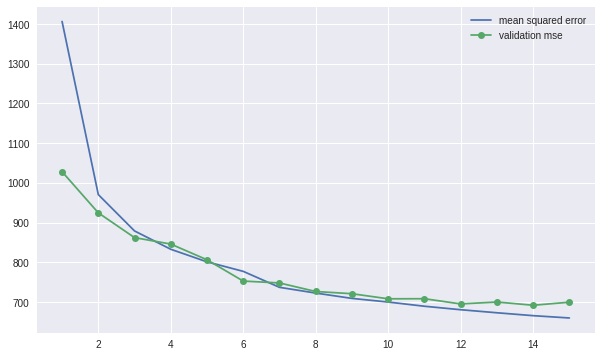

In [0]:
model1 = Sequential()
activ = 'elu'
model1.add(Dense(2**9, activation=activ))
model1.add(Dense(2**7, activation=activ))
model1.add(Dense(2**5, activation=activ))
model1.add(Dense(20, activation='linear', name='20dim_out'))
model1.add(Dense(2**7, activation=activ, name='20dim_in'))
model1.add(Dense(2**9, activation=activ))
model1.add(Dense(flattener.pixel_count, activation=activ))
model1.compile(loss='mean_squared_error', optimizer='adam')

history1 = model1.fit(X_train_flat, X_train_flat, batch_size = 32, epochs=15, validation_data=(X_val_flat, X_val_flat))

plt.figure(figsize=(10, 6))
x = range(1, len(history1.history['loss']) + 1)
plt.plot(x, history1.history['loss'], '-', label='mean squared error')
plt.plot(x, history1.history['val_loss'], '-o', label='validation mse')
plt.legend()
plt.show()

In [0]:
model1.save(os.path.join(path, 'model1.h5'))

In [0]:
model1 = load_model(os.path.join(path,'model1.h5'))

---
Create the encoder using the above neural network. The first half of the network performs the *transform* method, wheras the second is responsible for the *inverse_transform*. Combine it with the preprocessing transformer, and evaluate the whole encoder in the way that was used above to evaluate the SVD-based encoder.

In [0]:
class AutoEncoder(BaseEstimator, TransformerMixin):
  
    def __init__(self, model):
        self.model_in = K.function([model.layers[0].input], [model.get_layer('20dim_out').output])
        self.model_out = K.function([model.get_layer('20dim_in').input], [model.layers[-1].output])
        return None
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model_in([X])[0]
    
    def inverse_transform(self, X):
        return np.clip(self.model_out([X])[0], 0, 255)
      

In [0]:
encoder20_Dense = make_pipeline(flattener, AutoEncoder(model1))
f"train: {mse_img(X_train, encoder20_Dense)}, val: {mse_img(X_val, encoder20_Dense)}"

'train: 662.4718017578125, val: 694.7462768554688'

As before, reduce the dimension of the train-set images, reproduce them back and store in another variable. 

In [0]:
X_val_reproduced1 = reduce(X_val, encoder20_Dense)

---
Repeat the above scenario but with convolutional layers in place of the dense layers.

In [0]:
greyscale = GreyScale()
X_train_grey = greyscale.fit_transform(X_train)
X_val_grey = greyscale.transform(X_val)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 27s 492us/step - loss: 1801.5897 - val_loss: 1334.8883
Epoch 2/15
54000/54000 [==============================] - 25s 472us/step - loss: 1263.9217 - val_loss: 1208.3267
Epoch 3/15
54000/54000 [==============================] - 25s 472us/step - loss: 1151.9016 - val_loss: 1105.9746
Epoch 4/15
54000/54000 [==============================] - 25s 471us/step - loss: 1084.5254 - val_loss: 1054.2380
Epoch 5/15
54000/54000 [==============================] - 25s 471us/step - loss: 1044.3510 - val_loss: 1031.2155
Epoch 6/15
54000/54000 [==============================] - 25s 471us/step - loss: 1008.0359 - val_loss: 982.3766
Epoch 7/15
54000/54000 [==============================] - 25s 471us/step - loss: 984.7125 - val_loss: 977.5661
Epoch 8/15
54000/54000 [==============================] - 25s 471us/step - loss: 965.3494 - val_loss: 968.1930
Epoch 9/15
54000/54000 [============================

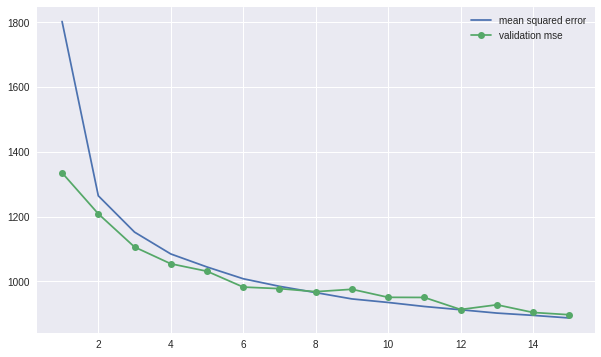

In [0]:
model2 = Sequential()
activ = 'elu'
model2.add(Conv2D(filters=32, kernel_size=(4,4), padding='same', activation=activ, input_shape=(28,28,1))) 
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=activ))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(filters=8, kernel_size=(2,2), padding='same', activation=activ))
model2.add(MaxPooling2D((3,3)))
model2.add(Conv2D(filters=5, kernel_size=(2,2), padding='same', activation=activ, name='20dim_out'))

model2.add(Conv2D(filters=32, kernel_size=(2,2), padding='same', activation=activ, name='20dim_in'))
model2.add(UpSampling2D((2,2)))
model2.add(Conv2D(filters=64, kernel_size=(4,4), padding='same', activation=activ))
model2.add(UpSampling2D((7,7)))
model2.add(Conv2D(filters=64, kernel_size=(4,4), padding='same', activation=activ))
model2.add(Conv2D(filters=1, kernel_size=(4,4), padding='same', activation=activ))

model2.compile(loss='mean_squared_error', optimizer='adam')

history2 = model2.fit(X_train_grey, X_train_grey, batch_size = 32, epochs=15, validation_data=(X_val_grey, X_val_grey))

plt.figure(figsize=(10, 6))
x = range(1, len(history2.history['loss']) + 1)
plt.plot(x, history2.history['loss'], '-', label='mean squared error')
plt.plot(x, history2.history['val_loss'], '-o', label='validation mse')
plt.legend()
plt.show()

In [0]:
model2.save(os.path.join(path, 'model2.h5'))

In [0]:
model2 = load_model(os.path.join(path,'model2.h5'))

In [0]:
encoder20_Conv = make_pipeline(greyscale, AutoEncoder(model2))
f"train: {mse_img(X_train[::10], encoder20_Conv)}, val: {mse_img(X_val, encoder20_Conv)}"

'train: 874.6467895507812, val: 895.0470581054688'

In [0]:
X_val_reproduced2 = reduce(X_val, encoder20_Conv)

---
Visualize the images reproduced by the three encoders from their corresponding 20-dimensional representations.

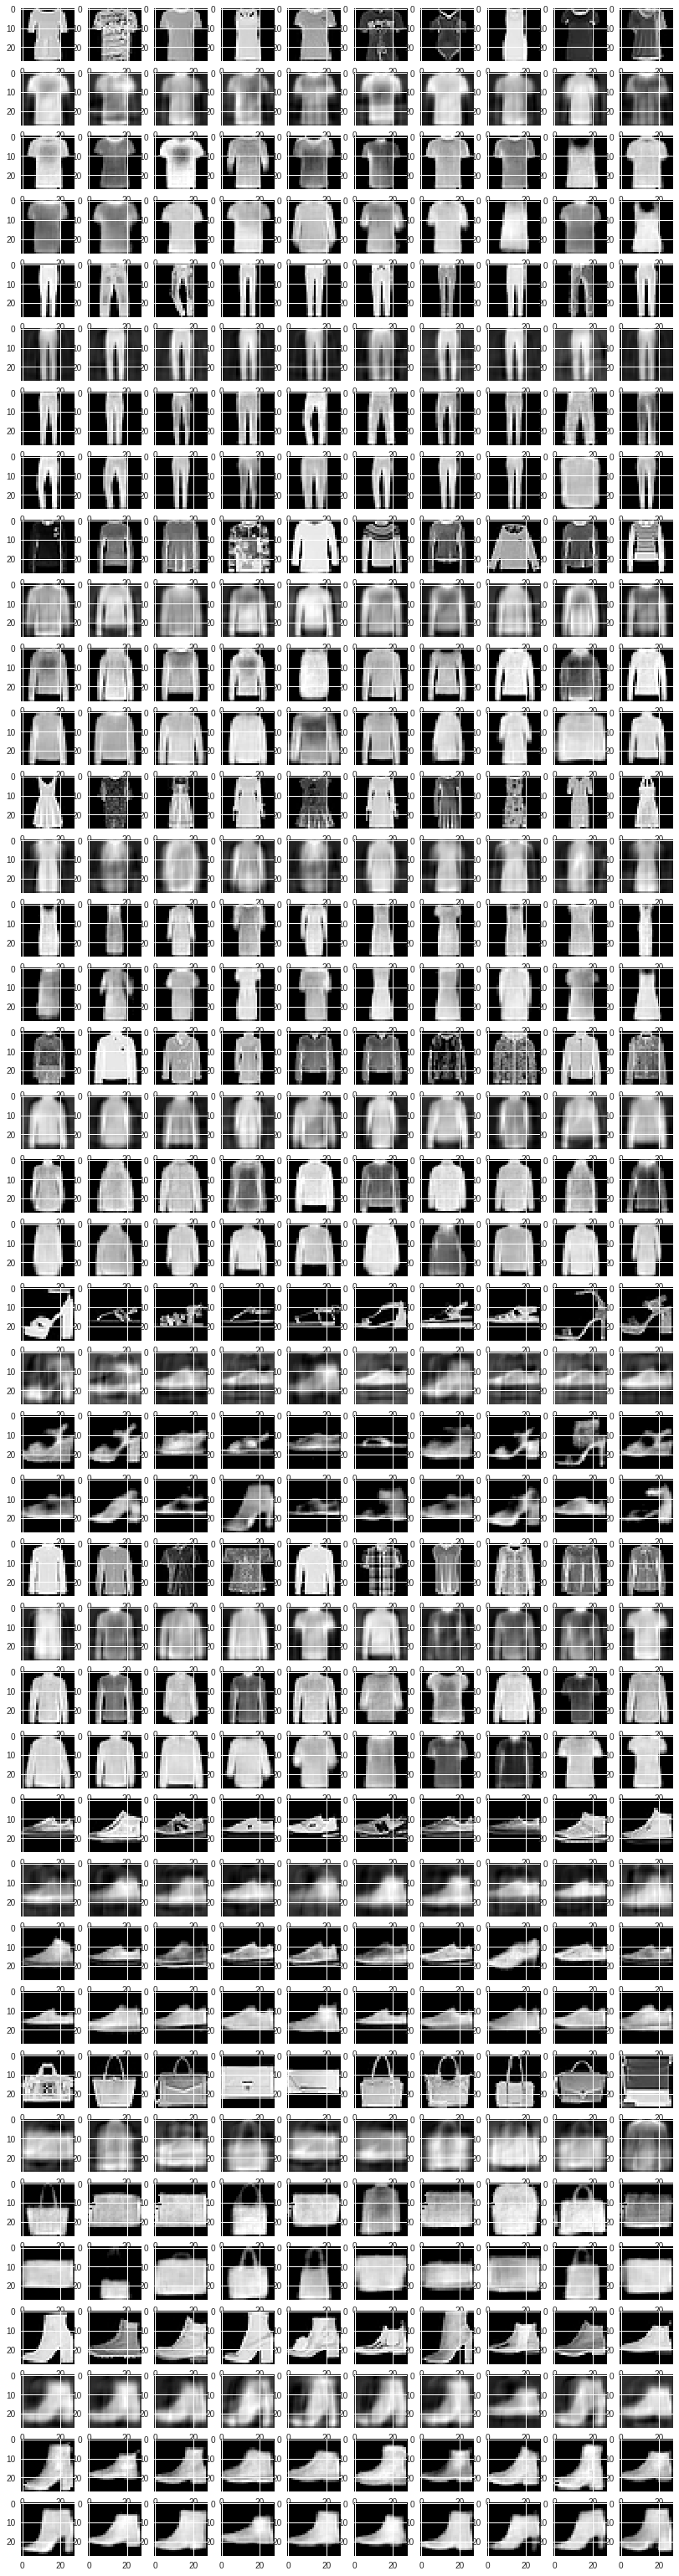

In [0]:
size = 14

image_streams = (X_val, X_val_reproduced0, X_val_reproduced1, X_val_reproduced2)
plt.figure(figsize=(size, size * len(image_streams)))


for row in range(10):
    for idx, image_stream in enumerate(image_streams):
        for column in range(10):
            ax = plt.subplot(10 * len(image_streams), 10, 10 * (row*len(image_streams) + idx) + column + 1)
            plt.imshow(image_stream[y_val==row][randint(0, np.sum(y_val==row)-1)], cmap='gray')

The auto-encoders do indeed seem to have easier time reproducing the images.

In the next notebook ('compression.ipynb') we compress all the images (including the test-set) passing them through the 20-dimensional representation, and we store them to file.

Then, in the notebook ''classification.ipynb' we undertake the prescribed classification task starting from the compressed images.

---
## End